In [1]:
import numpy as np
import torch

from matplotlib import pyplot as plt
from PIL import Image
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from vizer.draw import draw_boxes

from core.tops.config.instantiate import instantiate
from core.tops.torch_utils import to_cuda

from scripts.save_comparison_images import (
    convert_image_to_hwc_byte,
    get_config,
    get_dataloader,
    get_trained_model,
)

from tools.cam import (
    BackboneWrapper,
    pro_predict,
    renormalize_cam_in_bounding_boxes,
    retinafpn_reshape_transform,
)


## Selcect config, read image and setup model and loaders

In [2]:
CFG_PATH = "core/configs/task4/retina_P4_retrain_overfit.py"
cfg = get_config(CFG_PATH)
dataloader = get_dataloader(cfg, "val")

# IMG
image_url1 = "datasets/tdt4265_overfit/images/train/trip007_glos_Video00000_11.png"
raw_img = Image.open(image_url1)
image1 = np.array(raw_img)
image_float_np1 = np.float32(image1) / 255

# DATA
transform1 = instantiate(cfg.data_val.gpu_transform)
dataloader = iter(dataloader)

# MODEL
model1 = get_trained_model(cfg);

Loading config from: core/configs/task4/retina_P4_retrain_overfit.py
--------------------------------------------------------------------------------


2022-04-28 18:03:29,956 [INFO ] Loaded checkpoint from outputs/configs/task4/retina_P4_retrain_overfit/checkpoints/4019.ckpt


## Prepare baseline image

In [3]:
single_batch = next(dataloader)

In [4]:
cuda_image = to_cuda(single_batch["image"])
transformed_image = transform1({"image": cuda_image})["image"]

## Get initial predictions

In [5]:
SCORE_THRES = 0.92 # Tune this to your needs

boxes, labels, scores = pro_predict(transformed_image, single_batch, model1, SCORE_THRES)

## Draw initial predictions

In [6]:
base_image = convert_image_to_hwc_byte(single_batch["image"])
image = draw_boxes(base_image, boxes, labels, scores, class_name_map=cfg.label_map)

## Get CAM predictions

In [7]:
activation_targets = [FasterRCNNBoxScoreTarget(labels=labels, bounding_boxes=boxes)]

eigen_cam = EigenCAM(
    model = BackboneWrapper(model1),
    target_layers = [model1.feature_extractor],
    use_cuda=torch.cuda.is_available(),
    reshape_transform=retinafpn_reshape_transform
)

# Extract first image
grayscale_cam = eigen_cam(transformed_image, targets=activation_targets)[0, :]

# Convert base img to CAM base image (EigenCAM requires this)
cam_base_image = np.float32(base_image) / 255

## Draw CAM predictions

In [8]:
renormalized_cam = renormalize_cam_in_bounding_boxes(
    boxes,
    cam_base_image,
    grayscale_cam,
    boxes,
    labels,
    scores,
    cfg.label_map
)

# BEFORE CAM

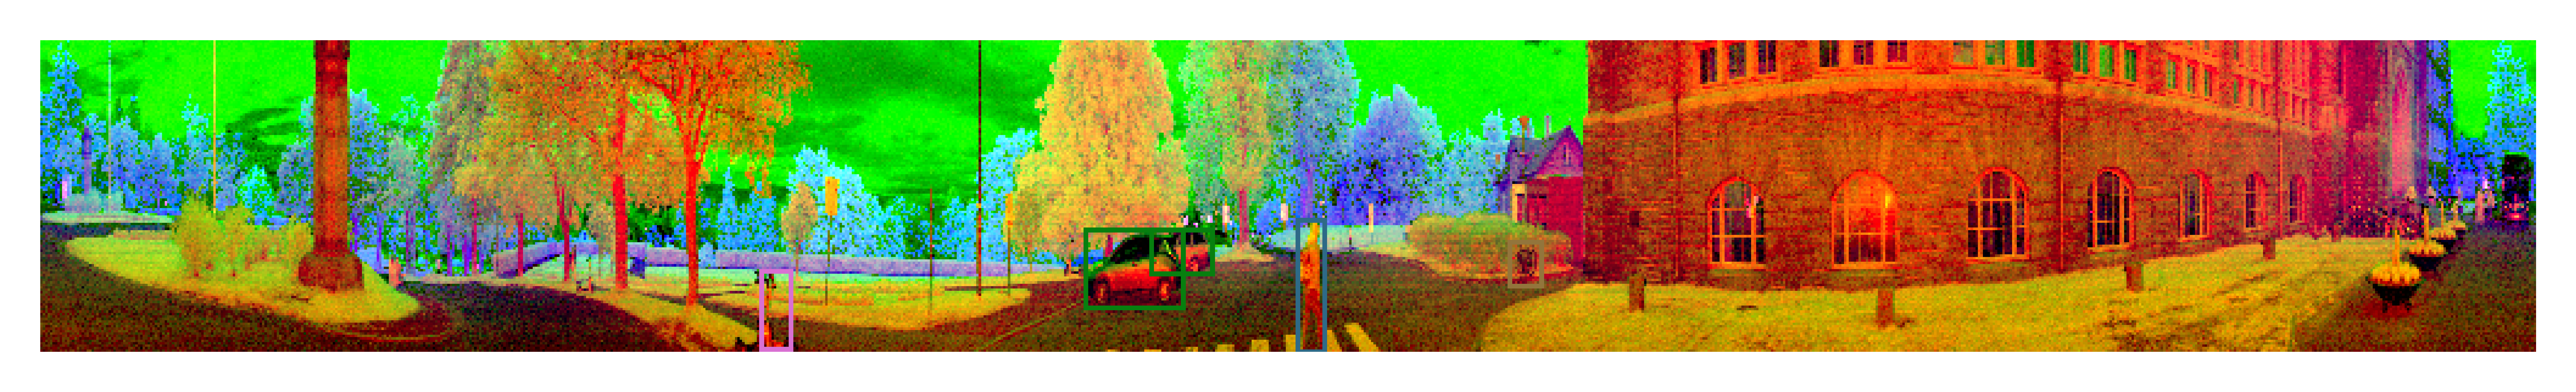

In [9]:
plt.figure(figsize=(8, 2), dpi=1200)
plt.axis("off")
plt.imshow(image)

# AFTER CAM

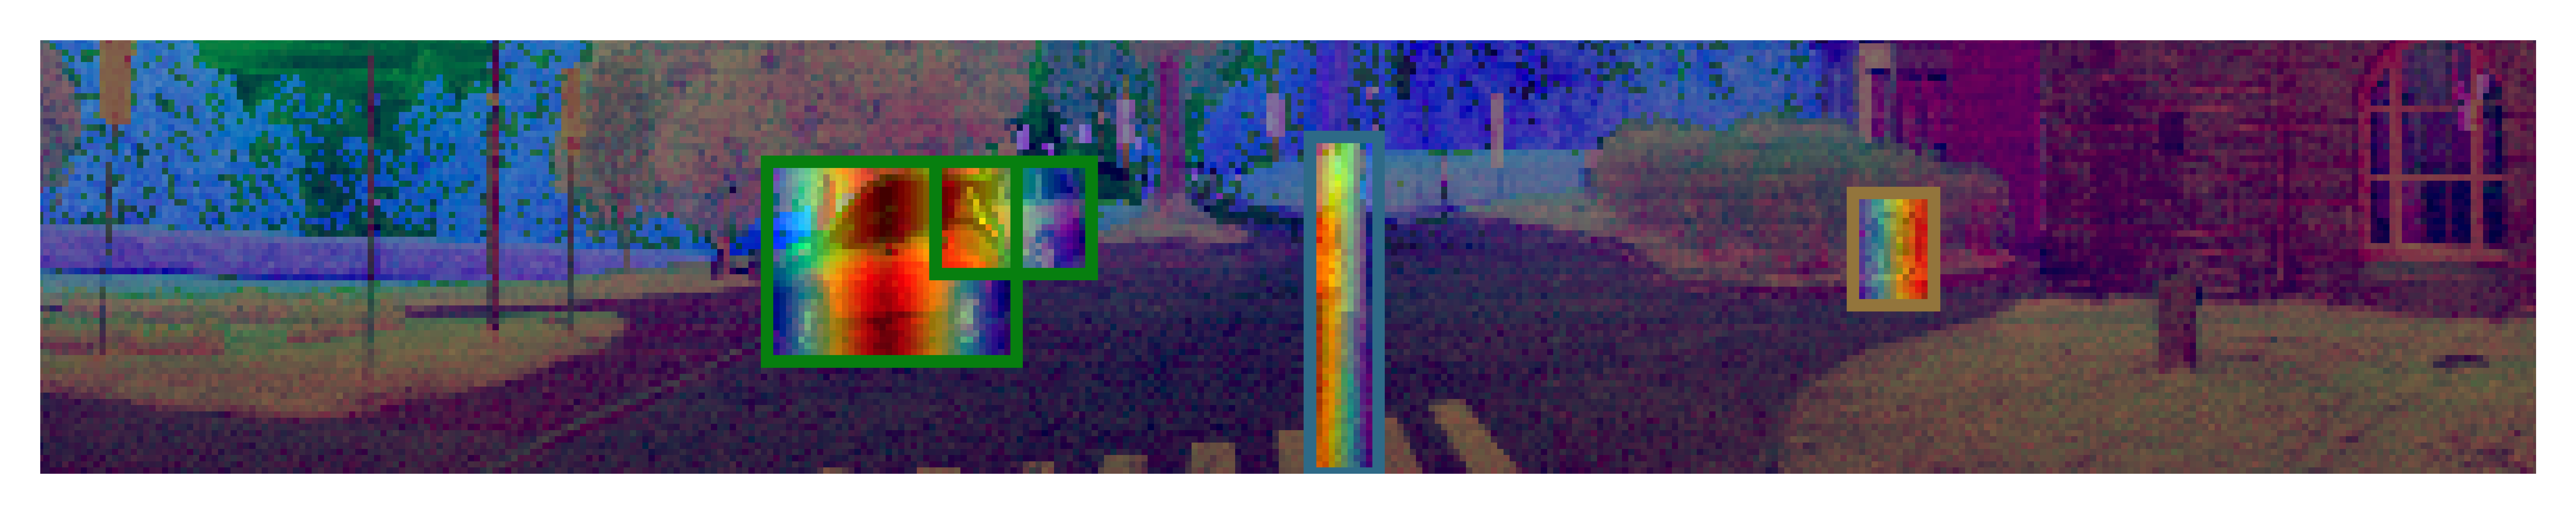

In [10]:
plt.figure(figsize=(8, 2), dpi=1200)
plt.axis("off")
plt.xlim(512-200, 512+200)
plt.ylim(128, 58)
plt.imshow(renormalized_cam)

| To remove catagory name and score probability from the vizualization, you have to go into the vizer src code and set display_string to None